In [73]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun # Importing RPS_Multirun class, used for main plots

from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi


import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import pandas as pd

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


np.random.seed(10) #setting seed for reproducible results 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# Helper Functions:
def logis(x):
    out = 1/(1 + np.exp(-x))
    return out

def log_odds(p):
    out = np.log(p/(1-p))
    return out


# 1. Individual Differences with Random Quitting


In [75]:
n_agents = 1000 # Number of learners in the simulation

# parameters varied:
alphas = np.random.uniform(low=0.4, high=0.8, size=n_agents) # learning rates
betas = np.random.uniform(low=0.1, high=0.3, size=n_agents) # forgetting rates

ass = np.random.uniform(low=0.1, high=0.3, size=n_agents) # min. practice rates
bs = np.random.uniform(low=3, high=7, size=n_agents) # success sensitivity

skill_maxs = np.random.uniform(low=0.5, high=1, size=n_agents) # Maximum skill levels
S0s = np.random.uniform(low=0.05, high=0.2, size=n_agents) # initial skills

# Constant parameters:
prac_rate0s = np.repeat(0.1, n_agents) # Initial practice rates


# lists for saving data:
S_finals_log = [] # final skills
PE_tots_log = [] # total practice events
S_at_quit_log = [] # skill at quitting time

practime_cache_log = [] # all prac times per learner
skills_cache_log = []  # all skill levels per learner

# ----- Simulations with Logistic Learning Curve -----
for i in range(n_agents):
    LC_log = logistic_learning(alpha=alphas[i], skill_max=skill_maxs[i]) # learning curve
    F_exp = exponential_forgetting(betas[i]) # forgetting curve 
    PR_simple = simple_linear_rate(a=ass[i], b=bs[i]) # practice rate

    # Simulate learning of agent i: 
    model_ = RPS_core(learning_func=LC_log,
                      forgetting_func=F_exp,
                      practice_rate_func=PR_simple,
                      waiting_time_dist=exponential_waiting_time,
                      initial_skill=S0s[i],
                      initial_practice_rate=prac_rate0s[i],
                      max_time=100)
    
    model_.run_simulation()


    # Store sim data:
    S_finals_log.append(model_.final_skill)
    PE_tots_log.append(model_.total_practice_events)  
    S_at_quit_log.append(model_.skill_levels[-2]) 

    practime_cache_log.append(model_.practice_times)
    skills_cache_log.append(model_.skill_levels) 



    

# Make dataframe:
df_log_ID_alpha = pd.DataFrame({'S_finals': S_finals_log, 
                            'PE_tots':PE_tots_log, 
                            'S_at_quit': S_at_quit_log})




Plots, lots of em:

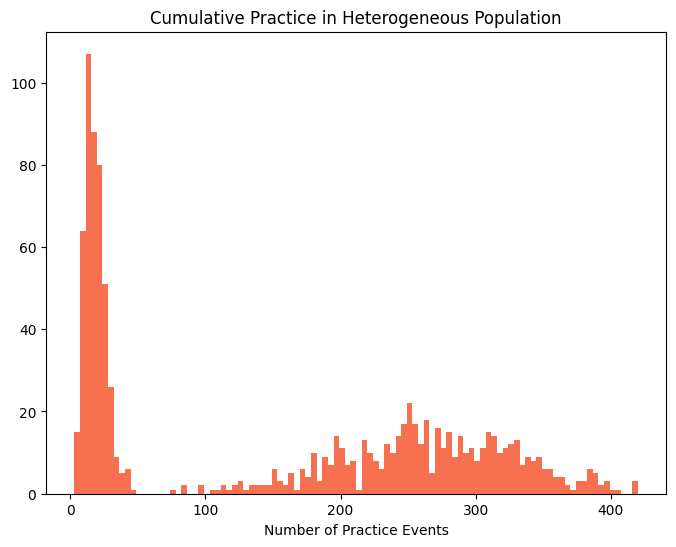

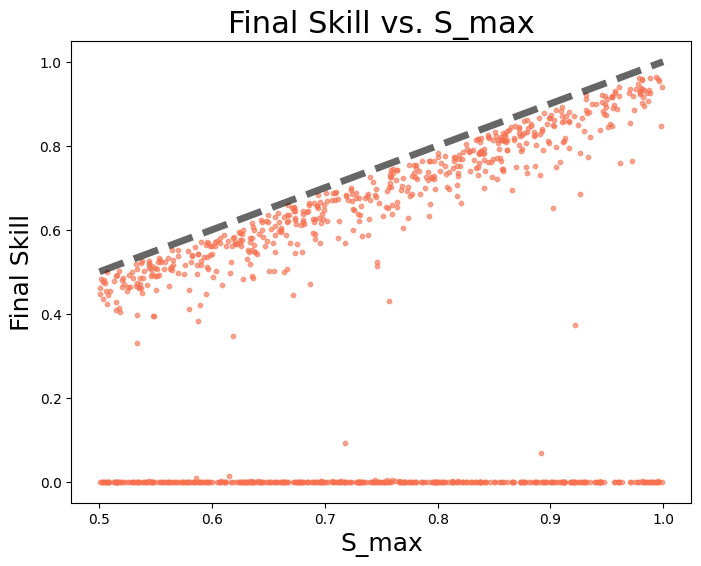

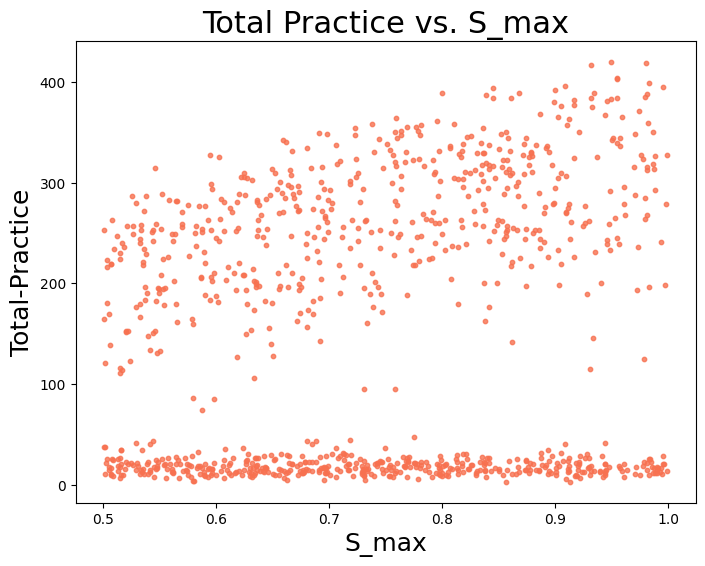

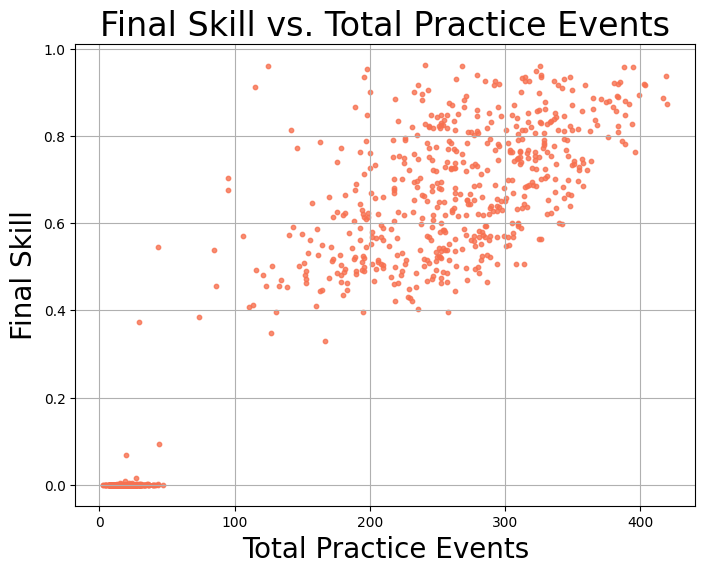

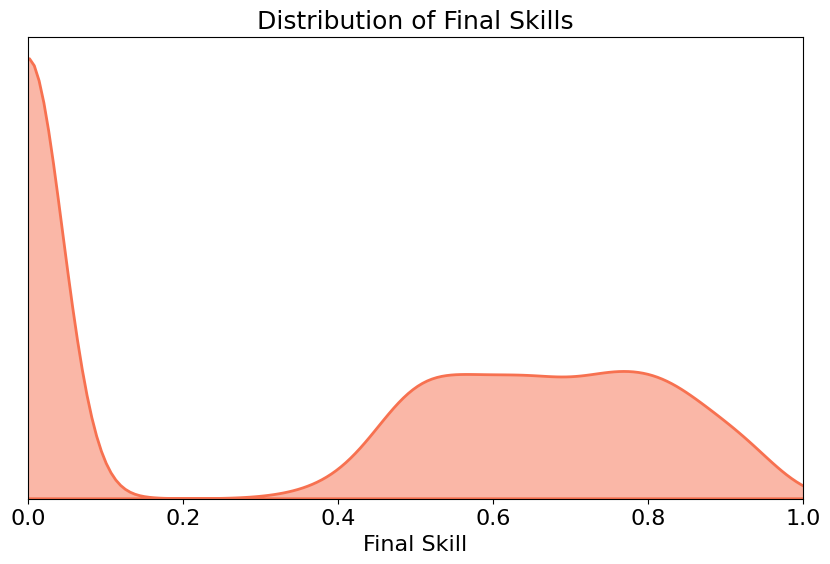

In [77]:


# ----- Plotting -------
dotsize=10

# Histogram of total practice events:
plt.figure(figsize=(8,6))
plt.hist(np.array(PE_tots_log), bins=100, color=sigmoid_colour, alpha=1)
plt.title('Cumulative Practice in Heterogeneous Population')
plt.xlabel('Number of Practice Events')
plt.show()



# ----- Effect of individual diffs. in S_max ------- 
# S_max vs. Final Skill
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, S_finals_log, s=dotsize, alpha=0.6, color=sigmoid_colour)
plt.plot([0.5, 1], [0.5, 1], color='black', lw=5, alpha=0.6, ls='--') # y=x line
plt.title('Final Skill vs. S_max',  fontsize=22)
plt.xlabel('S_max',  fontsize=18)
plt.ylabel('Final Skill',  fontsize=18)
plt.show()

# S_max vs. Tot. Practice Events
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, PE_tots_log, s=dotsize, alpha=0.8, color=sigmoid_colour)
plt.title('Total Practice vs. S_max', fontsize=22)
plt.xlabel('S_max', fontsize=18)
plt.ylabel('Total-Practice',  fontsize=18)
plt.show()



## --- Scatter plot - final skill vs. total practice events ------
plt.figure(figsize=(8, 6))  
plt.scatter(df_log_ID_alpha['PE_tots'], df_log_ID_alpha['S_finals'], 
            s=10, color=sigmoid_colour, alpha=0.8)
plt.title('Final Skill vs. Total Practice Events', fontsize=24)
plt.ylabel('Final Skill', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
#plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.grid(True)
plt.savefig('../plots/log_ID_Sf_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()

# ------ Distribution of Final Skills ------
plt.figure(figsize=(10, 6))

# Create the distribution plot
sns.kdeplot(
    data=df_log_ID_alpha['S_finals'],
    color=sigmoid_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    #bw_adjust=bw_adjust
    bw_adjust=0.5
)


# tick-params:
plt.tick_params(left = True, right = False , labelleft = True)
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks([], fontsize=16)
plt.ylabel('', fontsize=16)
plt.xlabel('Final Skill', fontsize=16)
plt.title('Distribution of Final Skills', fontsize=18)

plt.savefig('../plots/log_ID_alpha_final_skills.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()

 

Apply random quitting each time a learner practices, with a small probability $p_{rquit}$

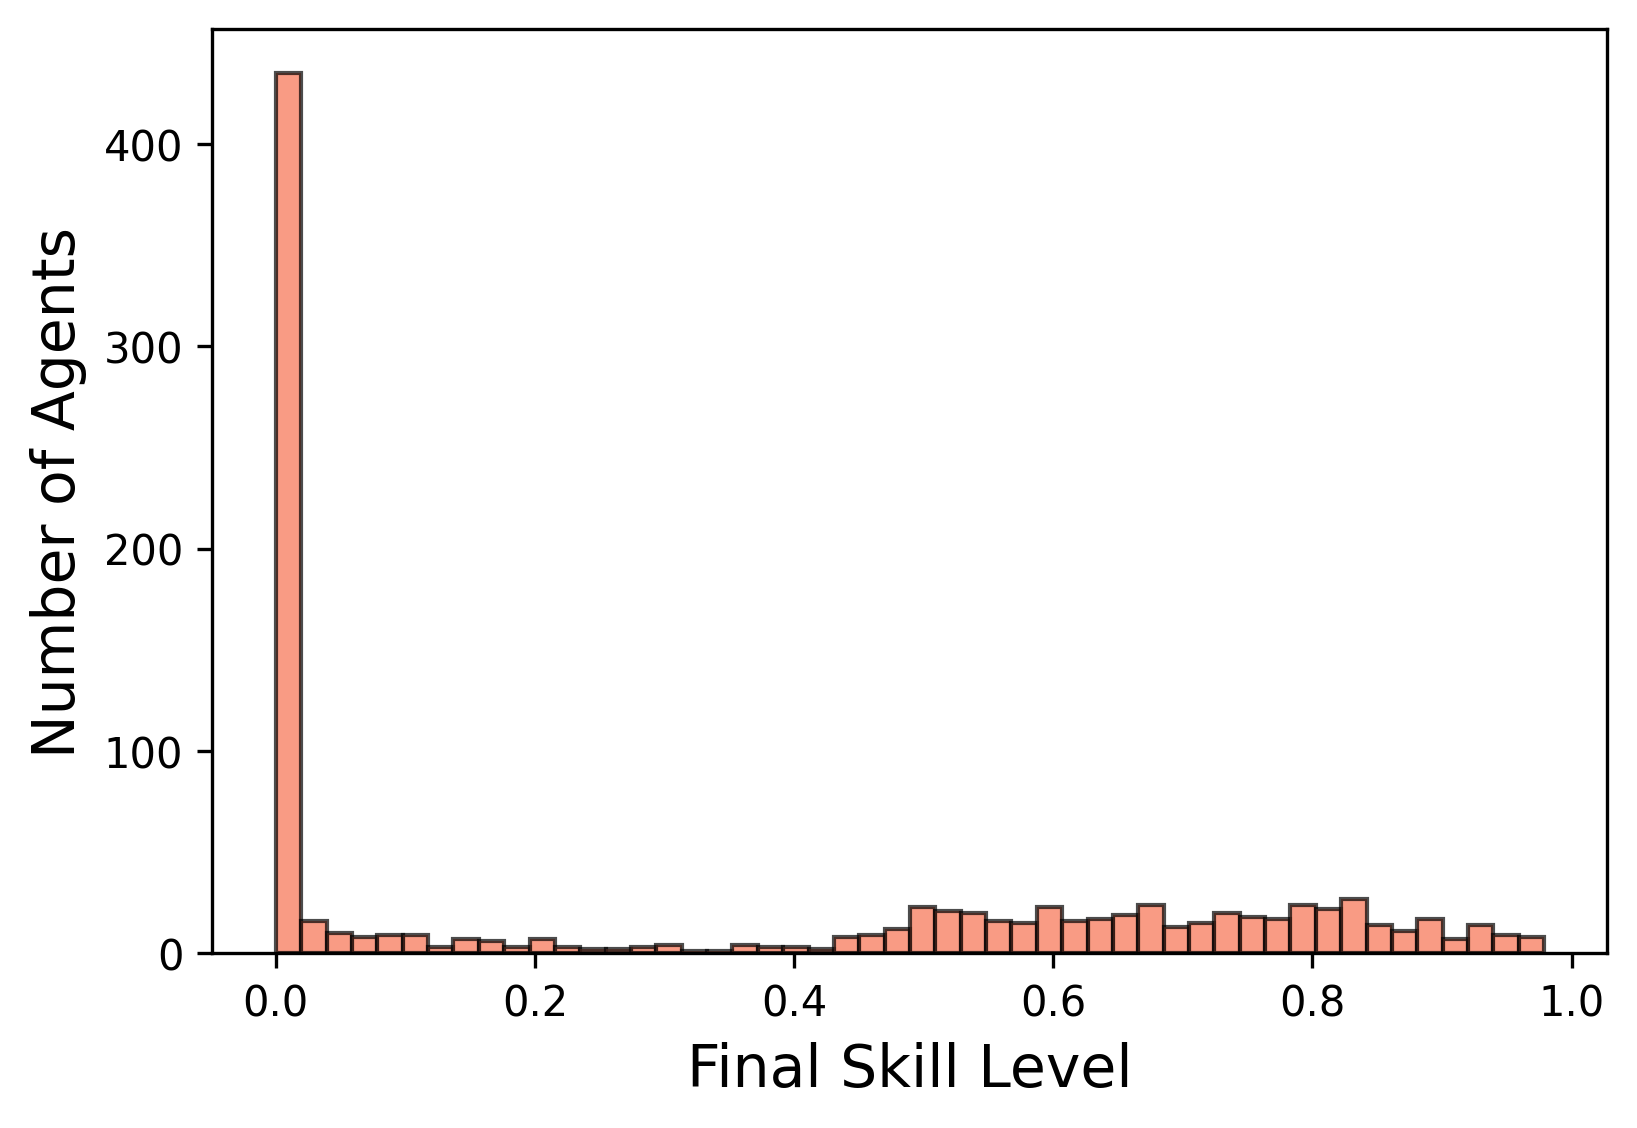

In [78]:
np.random.seed(5) 

# Apply random quitting:
p_rquit = 0.02 # probability of quitting after each practice event


# Apply random quitting:
s_final_rquit = []
prac_rquit = []

for i in range(n_agents):
    skills_ = skills_cache_log[i] # observed skill list
    n_prac_ = len(skills_) - 2 # total practice events
    
    # find index of practice event where random quitting occurs (if at all): 
    pidx_quit = np.random.geometric(p_rquit)  

    if pidx_quit < n_prac_: # if random quit is before end of sim
        s_final_rquit.append(skills_[pidx_quit])
        prac_rquit.append(pidx_quit)
    else:   # random quit after end of sim, no change
        s_final_rquit.append(skills_[-1])
        prac_rquit.append(n_prac_)
        

# Make dataframe:
df_rquit_sigmoid = pd.DataFrame({'S_at_quit': s_final_rquit, 
                                'PE_tots':prac_rquit}) 

df_rquit_sigmoid['logit-Skill'] = log_odds(df_rquit_sigmoid['S_at_quit']) 




# Plotting histogram of final skills with random quitting
plt.figure(figsize=(6,4), dpi=plot_dpi) 
plt.hist(s_final_rquit, bins=50, color=sigmoid_colour, edgecolor='black', alpha=0.7)
plt.xlabel('Final Skill Level', fontsize=14)
plt.ylabel('Number of Agents', fontsize=14)
plt.show()






See and save dataframe:

,S_at_quit,PE_tots,logit-Skill
0,4.904339e-04,13,-7.619729
1,1.760850e-10,18,-22.460055
2,4.667803e-01,12,-0.133075
3,5.538322e-01,125,0.216167
4,8.208994e-01,34,1.522453


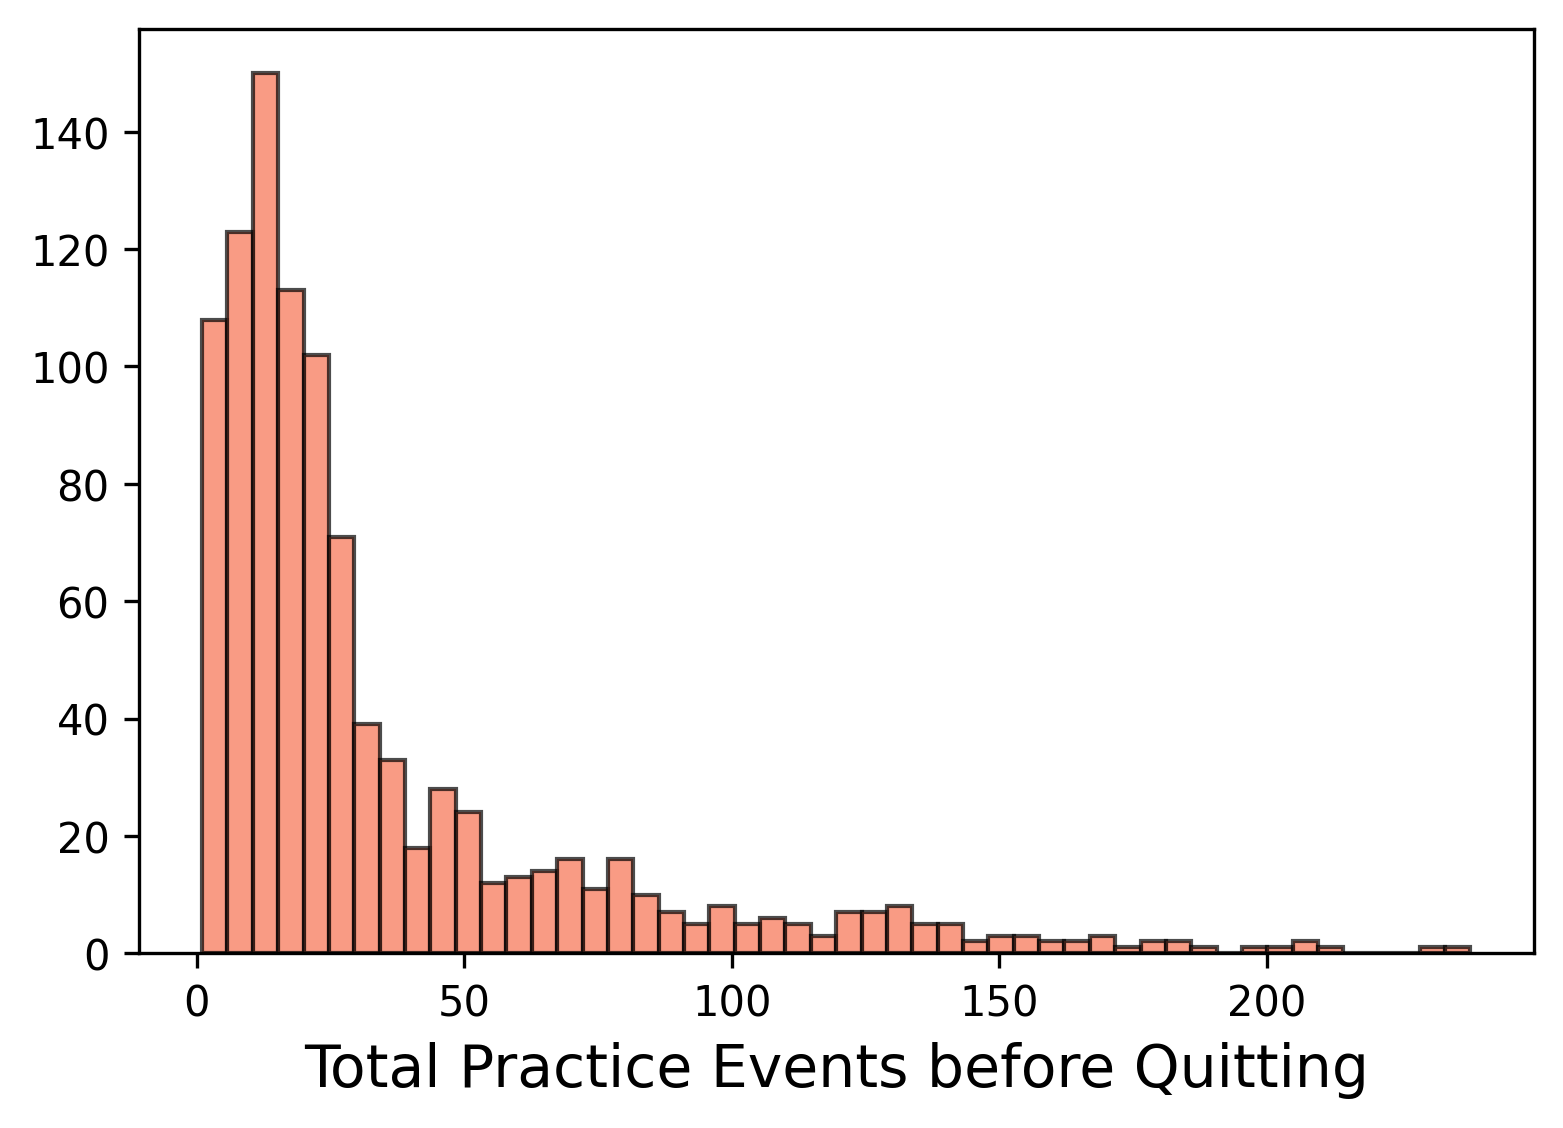

In [79]:
# see df:
display(df_rquit_sigmoid.head())

# save df:
df_rquit_sigmoid.to_csv('../data/log_ID_rquit.csv', index=False)

# Plotting histogram of total practice events with random quitting:
plt.figure(figsize=(6,4), dpi=plot_dpi)
plt.hist(df_rquit_sigmoid['PE_tots'], bins=50, color=sigmoid_colour, edgecolor='black', alpha=0.7)
plt.xlabel('Total Practice Events before Quitting', fontsize=14)
plt.show()

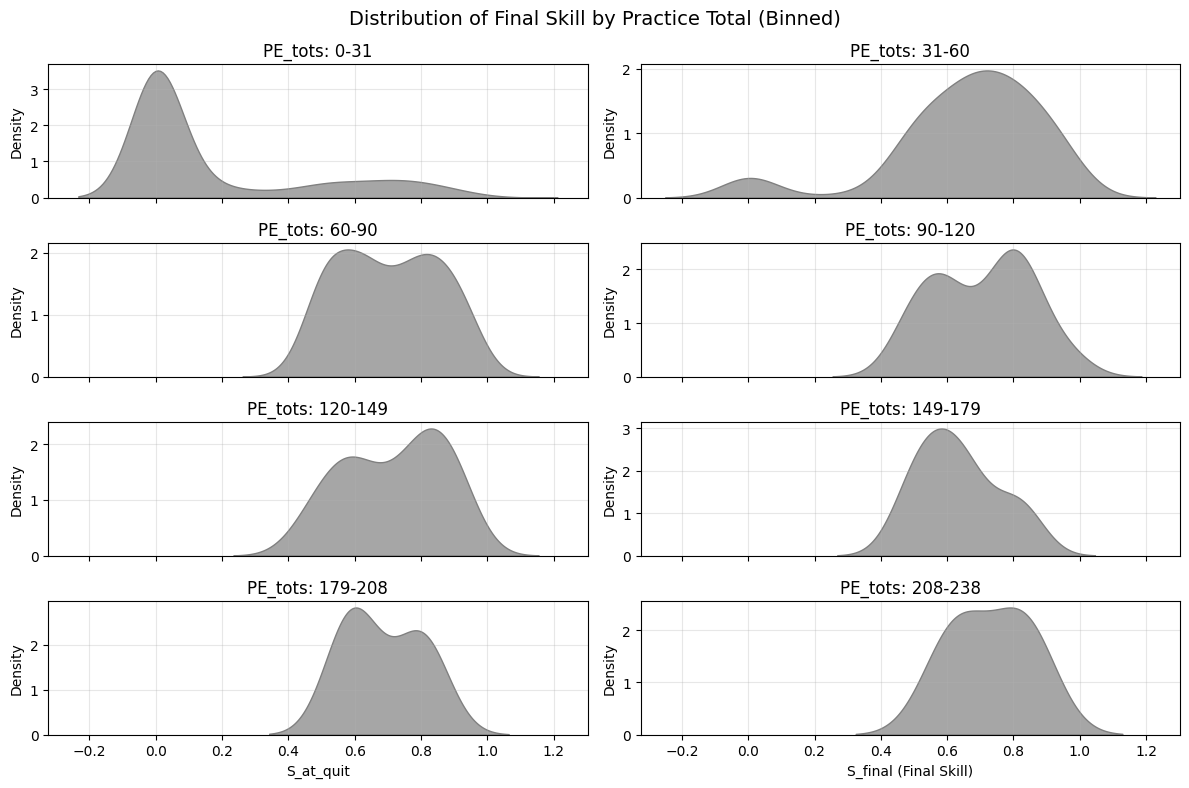

In [82]:
# Function to create PE_tots bins
def create_pe_bins(df, n_bins=5):
    """
    Create equal-sized bins for PE_tots values
    """
    # Create bins using pd.cut
    df_copy = df.copy()
    df_copy['PE_tots_binned'] = pd.cut(df_copy['PE_tots'], 
                                       bins=n_bins, 
                                       include_lowest=True,
                                       precision=0)
    
    # Create readable labels for the bins
    bin_labels = []
    for interval in df_copy['PE_tots_binned'].cat.categories:
        left = int(interval.left)
        right = int(interval.right)
        bin_labels.append(f"{left}-{right}")
    
    # Replace the interval objects with string labels
    df_copy['PE_tots_bin_label'] = df_copy['PE_tots_binned'].astype(str)
    for i, interval in enumerate(df_copy['PE_tots_binned'].cat.categories):
        df_copy.loc[df_copy['PE_tots_binned'] == interval, 'PE_tots_bin_label'] = bin_labels[i]
    
    return df_copy




# Method 1: Smoothed Density Plots (KDE) with binned PE_tots
def plot_density_by_bins(df, n_bins=5, figsize=(12, 8)):
    """
    Create density plots grouped by PE_tots bins
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    # Get unique bins and sort them
    unique_bins = df_binned['PE_tots_bin_label'].unique()
    # Sort by the lower bound of each bin
    unique_bins = sorted(unique_bins, key=lambda x: int(x.split('-')[0]))
    
    # Create subplots
    n_rows = int(np.ceil(n_bins / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize, sharex=True)
    if n_bins <= 2:
        axes = [axes] if n_bins == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, bin_label in enumerate(unique_bins):
        ax = axes[i] if n_bins > 1 else axes
        
        # Filter data for current bin
        bin_data = df_binned[df_binned['PE_tots_bin_label'] == bin_label]['S_at_quit']
        
        # Create KDE plot
        sns.kdeplot(data=bin_data, ax=ax, fill=True, alpha=0.7, color='gray')
        
        # Customize subplot
        ax.set_title(f'PE_tots: {bin_label}', fontsize=12)
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    if n_bins > 1:
        for j in range(len(unique_bins), len(axes)):
            axes[j].set_visible(False)
    
    plt.xlabel('S_final (Final Skill)')
    plt.suptitle('Distribution of Final Skill by Practice Total (Binned)', fontsize=14)
    plt.tight_layout()
    plt.show()



plot_density_by_bins(df_rquit_sigmoid, n_bins=8)